# Introducing Deep Learning on Satellite Data

Learning goals:
- See how a convolutional neural network (CNN) can be trained on small image patches from Sentinel-2.
- Understand the difference between using “tabular pixel samples + Random Forest” (what you’ve done already) versus “image patches + CNN” (deep learning).


________________________________________________________________________________
# Exercise: Deep Learning on Satellite Data (Cropland vs Non-Cropland)

In order to save time in class I have pre-prepped the patches to train from for you. The code used to do this given at the end of the notebook so that you can use it to generate your own patches in the future.

In this exercise, you will use the Sentinel-2 image patches to train a simple deep learning model that can distinguish between cropland and non-cropland.

We will go through five stages:

      1.) Loading the patch dataset

      2.) Preprocessing the data

      3.) Building a simple Convolutional Neural Network (CNN)

      4.) Training the model

      5.) Evaluating the model

At the end, you will reflect on what you have learned and think about possible improvements.

In [2]:
# Setup
# !pip install tensorflow matplotlib --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/homebrew/Caskroom/miniconda/base/envs/geo/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/geo/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/geo/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/cor

## Step 1: Load pre-generated dataset
The .npz file is available via the class GitHub or Canvas.

The patches have already been extracted from a median cloud-free Sentinel-2 composite. Each patch is a small image (64 × 64 × 3 pixels) with a label:
- 1 = cropland
- 0 = non-cropland

Upload the patches ('mount' them into our Colab drive) by just dragging and dropping the .npz file into the 'Files' tab. This is the same tab that you uploaded the .zip file in a prior lab.

In [3]:
# Load the dataset
data = np.load("patches.npz")
X, y = data["X"], data["y"]

print("Patch dataset loaded")
print("X shape:", X.shape)  # (num_patches, 64, 64, 3)
print("y shape:", y.shape)  # (num_patches,)

Patch dataset loaded
X shape: (12, 64, 64, 3)
y shape: (12,)


In [18]:
y[0:10]  # Display first 10 labels

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

At this point, X contains the image data and y contains the binary labels.

# Step 2: Preprocess the data

Machine learning models train best when the inputs are normalized (scaled to a common range). Sentinel-2 reflectance values can be large, so we will rescale them to approximately [0, 1]. Notice that we are not normalizing patch-by-patch (which can distort values and remove contrast), but rather scaling consistently across the whole dataset.

We also split the data into training and testing sets. The training set is used to fit the model, while the test set evaluates how well the model generalizes to new data.

In [ ]:
# Convert to float32
X = X.astype("float32")

# Find the global maximum value across ALL patches
global_max = X.max()
print("Global max reflectance across dataset:", global_max)

# Scale all patches by this global max
X /= global_max

print("Scaled X range:", X.min(), X.max())

# Optional: double-check shape
print("X shape:", X.shape, "y shape:", y.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


Global max reflectance across dataset: 1.0
Scaled X range: 0.0 1.0
X shape: (12, 64, 64, 3) y shape: (12,)
X shape: (12, 64, 64, 3) y shape: (12,)


# Step 3: Build a simple CNN classifier

We’ll use a basic Convolutional Neural Network (CNN) with a few layers to classify patches.

A CNN is the standard type of neural network for image classification.
It works by applying small filters (convolutions) that detect local features such as edges, textures, and patterns, and then combining these features to make a classification.

Here we build a very small CNN:
- Two convolutional + pooling layers (feature extraction). More these in future lectures.
- A dense hidden layer (decision making)
- An output layer with a single unit and sigmoid activation (binary classification)

In [5]:
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation="relu", input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # binary classification
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/geo/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,625 (1.55 MB)

 Trainable params: 406,625 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

# Step 4: Train the model

Now we can train the model using our training data. During training, the model will repeatedly adjust its internal parameters to minimize the classification error.

We will train for 10 epochs (iterations over the whole training dataset), using small batches of 8 patches at a time.

You should see the training accuracy improve over time.

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=8
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - loss: 0.7178 - val_accuracy: 0.5000 - val_loss: 0.6603
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 0.6371 - val_accuracy: 0.5000 - val_loss: 0.6272
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 0.5725 - val_accuracy: 0.5000 - val_loss: 0.6060
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6250 - loss: 0.5089 - val_accuracy: 1.0000 - val_loss: 0.5826
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.4489 - val_accuracy: 1.0000 - val_loss: 0.5385
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.3839 - val_accuracy: 1.0000 - val_loss: 0.4957
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.3230 - val_accuracy: 1.0000 - val_loss: 0.4598
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.2615 - val_accuracy: 1.0000 - val_loss: 0.4389
E

# Step 5: Evaluate the model

Finally, let’s check how well the model performed on unseen test data, and also visualize the training history.

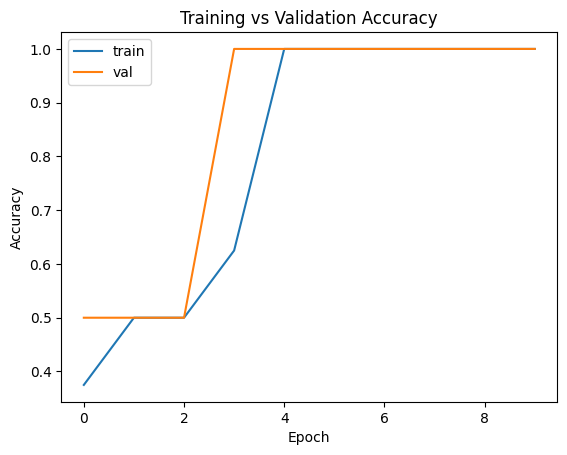

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.3404
Test accuracy: 1.0


In [ ]:
# Plot training history
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()

# Final evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Finally, let's take a look at our patches and sense check that we have indeed classified them correctly.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


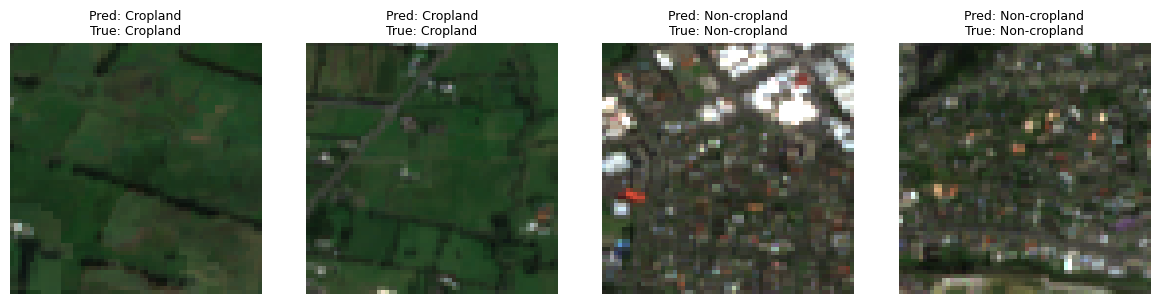

In [8]:
def show_classified_patches(X, y_true, y_pred, n=12):
    """
    Display patches in a grid with their predicted class.

    Args:
        X (np.array): Image patches, shape (N, H, W, C).
        y_true (np.array): Ground truth labels.
        y_pred (np.array): Predicted labels.
        n (int): Number of patches to display.
    """
    # Pick the first n patches (or all if fewer exist)
    n = min(n, X.shape[0])
    cols = 4
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))
    axes = axes.flatten()

    for i in range(n):
        axes[i].imshow(X[i])
        true_label = "Cropland" if y_true[i] == 1 else "Non-cropland"
        pred_label = "Cropland" if y_pred[i] == 1 else "Non-cropland"
        axes[i].set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=9)
        axes[i].axis("off")

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()



y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
show_classified_patches(X_test, y_test, y_pred, n=12)

Hmmm some good some bad there! But overall not a bad effort given how little training data we have.

# Questions

1. What is the final test accuracy of your model?

2. How do the training and validation accuracy curves compare?

3. Do you see signs of overfitting (training >> validation)?

4. If you had more patches, how might this affect the model performance?

5. What are some ways we could improve this experiment? Think about the answer to Q4 here in particular...

________________________________________________________________________________

# Patch prep code
Here is the code that I used to generate the patches. This is not required for the exercise, but could be useful in future labs and in your project.

In [9]:
# # The usual prep
# !pip install geemap --quiet

# import geemap
# import geopandas as gpd
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import os

# import ee
# ee.Authenticate()
# ee.Initialize(project='earthengine-ml-testing') #<- Remember to change this to your own project's name!

In [10]:
# # Prep our S2 image usng what we learned in Lab 3
# def get_s2_sr_cld_col(aoi, start_date, end_date):
#     # Import and filter S2 SR.
#     s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
#         .filterBounds(aoi)
#         .filterDate(start_date, end_date)
#         .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

#     # Import and filter s2cloudless.
#     s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
#         .filterBounds(aoi)
#         .filterDate(start_date, end_date))

#     # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
#     return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
#         'primary': s2_sr_col,
#         'secondary': s2_cloudless_col,
#         'condition': ee.Filter.equals(**{
#             'leftField': 'system:index',
#             'rightField': 'system:index'
#         })
#     }))


# def add_cloud_bands(img):
#     # Get s2cloudless image, subset the probability band.
#     cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

#     # Condition s2cloudless by the probability threshold value.
#     is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

#     # Add the cloud probability layer and cloud mask as image bands.
#     return img.addBands(ee.Image([cld_prb, is_cloud]))


# def add_shadow_bands(img):
#     # Identify water pixels from the SCL band.
#     not_water = img.select('SCL').neq(6)

#     # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
#     SR_BAND_SCALE = 1e4
#     dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

#     # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
#     shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

#     # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
#     cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
#         .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
#         .select('distance')
#         .mask()
#         .rename('cloud_transform'))

#     # Identify the intersection of dark pixels with cloud shadow projection.
#     shadows = cld_proj.multiply(dark_pixels).rename('shadows')

#     # Add dark pixels, cloud projection, and identified shadows as image bands.
#     return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))


# def add_cld_shdw_mask(img):
#     # Add cloud component bands.
#     img_cloud = add_cloud_bands(img)

#     # Add cloud shadow component bands.
#     img_cloud_shadow = add_shadow_bands(img_cloud)

#     # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
#     is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

#     # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
#     # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
#     is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
#         .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
#         .rename('cloudmask'))

#     # Add the final cloud-shadow mask to the image.
#     return img_cloud_shadow.addBands(is_cld_shdw)


# # Define a function to apply the cloud mask to the S2 spectral bands
# def apply_cld_shdw_mask(img):
#     cloudmask = img.select('cloudmask')
#     # Mask cloudy pixels
#     masked_img = img.updateMask(cloudmask.Not())
#     # Keep cloudmask and probability bands
#     cloudmask_band = img.select('cloudmask')
#     probability_band = img.select('probability')
#     masked_img = masked_img.addBands([cloudmask_band, probability_band], overwrite=True)
#     return masked_img




# # ---------- Controls ----------
# AOI = ee.Geometry.Point(174.7633, -36.8485)
# START_DATE = '2023-01-01'
# END_DATE = '2023-03-31'
# CLOUD_FILTER = 60
# CLD_PRB_THRESH = 50
# NIR_DRK_THRESH = 0.15
# CLD_PRJ_DIST = 1
# BUFFER = 50

# # --------- Generate stack ------
# # Get the collection
# s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

# # Process the collection
# s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
#                              .map(apply_cld_shdw_mask)
#                              .median())

In [11]:
# def extract_patch(image, point, size=64, scale=10):
#     region = point.buffer(size * scale / 2).bounds()
#     patch = geemap.ee_to_numpy(
#         image,
#         region=region,
#         bands=['B4', 'B3', 'B2'],
#         scale=scale
#     )
#     if patch is None:
#         return None

#     # Force consistent patch size (size, size, 3)
#     h, w, c = patch.shape
#     target = (size, size, c)
#     patch_fixed = np.zeros(target, dtype=patch.dtype)

#     h_min = min(h, size)
#     w_min = min(w, size)
#     patch_fixed[:h_min, :w_min, :] = patch[:h_min, :w_min, :]

#     return np.clip(patch_fixed / 3000, 0, 1)

# def save_patches(image, cropland_pts, non_cropland_pts, outfile="patches.npz", size=64, scale=10):
#     X_list, y_list, coords = [], [], []

#     # Cropland first (label=1)
#     for pt in cropland_pts:
#         p = extract_patch(image, pt, size=size, scale=scale)
#         if p is not None:
#             X_list.append(p)
#             y_list.append(1)
#             coords.append(pt.coordinates().getInfo())  # [lon, lat]

#     # Non-cropland (label=0)
#     for pt in non_cropland_pts:
#         p = extract_patch(image, pt, size=size, scale=scale)
#         if p is not None:
#             X_list.append(p)
#             y_list.append(0)
#             coords.append(pt.coordinates().getInfo())  # [lon, lat]

#     if len(X_list) == 0:
#         raise RuntimeError("No patches extracted.")

#     X = np.stack(X_list, axis=0)
#     y = np.array(y_list, dtype=int)
#     coords = np.array(coords, dtype=float)  # shape (N,2) [lon,lat]

#     np.savez_compressed(outfile, X=X, y=y, coords=coords)

#     print(f"Saved {X.shape[0]} patches to {os.path.abspath(outfile)}")
#     print(f"  Cropland patches (y==1): {(y==1).sum()}")
#     print(f"  Non-cropland patches (y==0): {(y==0).sum()}")
#     print(f"  Patch shape: {X.shape[1:]}")
#     return X, y, coords


# def show_patches(X, y, coords=None, n=3):
#     cropland_idx = np.where(y == 1)[0]
#     non_idx = np.where(y == 0)[0]

#     n = min(n, len(cropland_idx), len(non_idx))
#     if n == 0:
#         print("No patches to display.")
#         return

#     fig, axes = plt.subplots(2, n, figsize=(5*n, 8))
#     if n == 1:
#         axes = np.array([[axes[0]], [axes[1]]])  # normalize shape

#     # Top row: cropland
#     for i in range(n):
#         idx = cropland_idx[i]
#         axes[0, i].imshow(X[idx])
#         if coords is not None:
#             lon, lat = coords[idx]
#             axes[0, i].set_title(f"Cropland (1)\n{lat:.4f}, {lon:.4f}")
#         else:
#             axes[0, i].set_title("Cropland (1)")
#         axes[0, i].axis("off")

#     # Bottom row: non-cropland
#     for i in range(n):
#         idx = non_idx[i]
#         axes[1, i].imshow(X[idx])
#         if coords is not None:
#             lon, lat = coords[idx]
#             axes[1, i].set_title(f"Non-crop (0)\n{lat:.4f}, {lon:.4f}")
#         else:
#             axes[1, i].set_title("Non-crop (0)")
#         axes[1, i].axis("off")

#     plt.tight_layout()
#     plt.show()

In [12]:
# # Define example points
# cropland_points = [
#     ee.Geometry.Point([174.952922, -37.024492]),
#     ee.Geometry.Point([174.554596, -36.788981]),
#     ee.Geometry.Point([174.936961, -37.032787]),
#     ee.Geometry.Point([174.551965, -36.807036]),
#     ee.Geometry.Point([174.556182, -36.801054]),
#     ee.Geometry.Point([174.567911, -36.808468])
# ]
# non_cropland_points = [
#     ee.Geometry.Point([174.821293, -36.916761]),
#     ee.Geometry.Point([174.879206, -36.919512]),
#     ee.Geometry.Point([174.942332, -37.055910]),
#     ee.Geometry.Point([174.940074, -37.065542]),
#     ee.Geometry.Point([174.543226, -36.770280]),
#     ee.Geometry.Point([174.910122, -37.038162])
# ]

# # Run
# X, y, coords = save_patches(s2_sr_median, cropland_points, non_cropland_points, "patches.npz")
# show_patches(X, y, coords, n=6)